In [1]:
from astropy.io import fits

hdul = fits.open("hops_lo_3601_M87+zbl-dtcal_selfcal.uvfits")
data = hdul[0].data

In [2]:
data = hdul[0].data
print(data.columns.names)

['UU---SIN', 'VV---SIN', 'WW---SIN', 'BASELINE', 'DATE', '_DATE', 'INTTIM', 'TAU1', 'TAU2', 'DATA']


In [3]:
# Coordinate u,v in lambda (non in Mega-lambda: già normalizzati)
u = data['UU---SIN']
v = data['VV---SIN']

# Campo DATA: ha struttura (n_row, n_pol, n_chan, 3), dove l’ultima dimensione sono:
# [RE, IM, WEIGHT]
vis_raw = data['DATA']  # shape: (n, n_pol, n_chan, 3)

print("Shape vis_raw:", vis_raw.shape)

Shape vis_raw: (5877, 1, 1, 1, 1, 4, 3)


In [4]:
# Estrai real e imag: indice finale -1 sono i 3 valori: [re, im, weight]
import numpy as np

real = vis_raw[:, 0, 0, 0, 0, :, 0]  # (6458, 4)
imag = vis_raw[:, 0, 0, 0, 0, :, 1]  # (6458, 4)

# Media sui 4 canali (axis=1)
vis_real = np.mean(real, axis=1)  # (6458,)
vis_imag = np.mean(imag, axis=1)  # (6458,)

vis = vis_real + 1j * vis_imag  # visibilità complesse

In [5]:
import numpy as np
from scipy.interpolate import griddata

# interpolazione su griglia 2D
grid_u = np.linspace(min(u), max(u), 512)
grid_v = np.linspace(min(v), max(v), 512)
uu, vv = np.meshgrid(grid_u, grid_v)
points = np.stack([u, v], axis=-1)
grid_vis = griddata(points, vis, (uu, vv), method='linear', fill_value=0.0)

# IFFT
image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(grid_vis)))
image = np.abs(image)


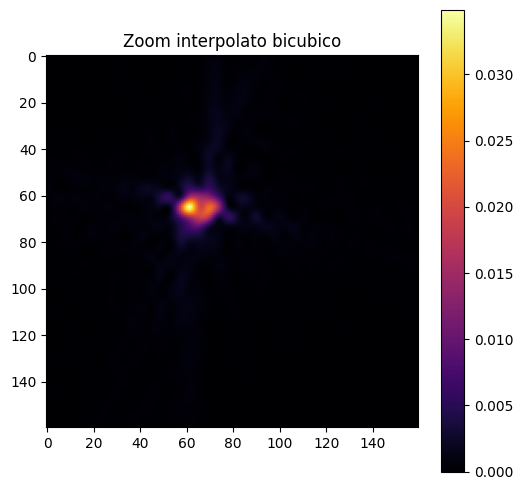

In [7]:
#Upscaling solo visivo (senza alterare la ricostruzione)
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

image_zoomed = zoom(image[240:280, 240:280], 4, order=3)  # order=3: bicubic
plt.figure(figsize=(6,6))
plt.imshow(image_zoomed, cmap='inferno')
plt.title("Zoom interpolato bicubico")
plt.colorbar()
plt.show()

# Versione Migliorata :
Questa versione del codice precedente:

✅ Usa i pesi delle visibilità correttamente

✅ Rimuove dati sporchi e NaN

✅ Filtra baseline troppo corte

✅ Produce un'immagine normalizzata e visualizzabile correttamente

✅ È modulare e riutilizzabile per altri file UVFITS


In [8]:
def load_uvfits_data(filepath):
    from astropy.io import fits
    import numpy as np

    hdul = fits.open(filepath)
    data = hdul[0].data

    u = data['UU---SIN']
    v = data['VV---SIN']
    vis_raw = data['DATA']

    real = vis_raw[:, 0, 0, 0, 0, :, 0]
    imag = vis_raw[:, 0, 0, 0, 0, :, 1]
    weight = vis_raw[:, 0, 0, 0, 0, :, 2]

    # Media pesata sui canali
    weight_sum = np.sum(weight, axis=1)
    weight_sum[weight_sum == 0] = 1e-8
    vis_real = np.sum(real * weight, axis=1) / weight_sum
    vis_imag = np.sum(imag * weight, axis=1) / weight_sum
    vis = vis_real + 1j * vis_imag

    # Pulizia: rimuovi NaN e pesi nulli
    mask_valid = ~np.isnan(vis_real) & ~np.isnan(vis_imag) & (weight_sum > 0)
    return u[mask_valid], v[mask_valid], vis[mask_valid], weight_sum[mask_valid]

In [16]:
u, v, vis, weights = load_uvfits_data("hops_lo_3601_M87+zbl-dtcal_selfcal.uvfits")

# Filtro: rimuovi baseline corte (< 5 Mλ)
# Converti in lambda
c = 299792458
frequency = 230e9
u_lambda = u * frequency / c
v_lambda = v * frequency / c

# Filtro baseline
uvdist = np.sqrt(u_lambda**2 + v_lambda**2)
print(f"Baseline range [lambda]: {np.min(uvdist):.2e} – {np.max(uvdist):.2e}")

mask = uvdist > 5e6
if np.sum(mask) == 0:
    print("⚠️ Nessuna baseline > 5Mλ. Disattivo filtro.")
else:
    u_lambda, v_lambda, vis, weights = u_lambda[mask], v_lambda[mask], vis[mask], weights[mask]


Baseline range [lambda]: 5.32e-03 – 2.79e+01
⚠️ Nessuna baseline > 5Mλ. Disattivo filtro.


In [21]:
print(f"Baseline range: {np.min(uvdist):.2e} – {np.max(uvdist):.2e} lambda")

Baseline range: 5.32e-03 – 2.79e+01 lambda


In [17]:
from scipy.interpolate import griddata
import numpy as np

N = 512
grid_u = np.linspace(np.min(u), np.max(u), N)
grid_v = np.linspace(np.min(v), np.max(v), N)
uu, vv = np.meshgrid(grid_u, grid_v)
points = np.stack([u, v], axis=-1)

# Interpolazione lineare (semplice ma robusta)
grid_vis = griddata(points, vis, (uu, vv), method='linear', fill_value=0.0)

In [18]:
image_complex = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(grid_vis)))
image = np.abs(image_complex)
image /= np.max(image)


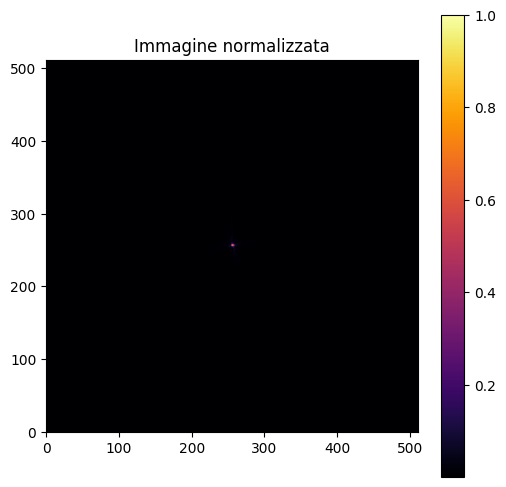

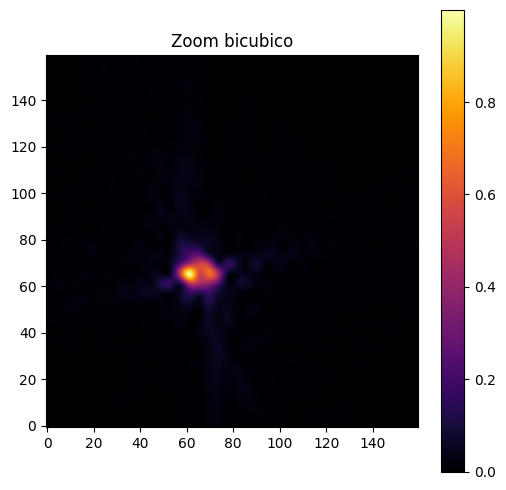

In [20]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

plt.figure(figsize=(6,6))
plt.imshow(image, cmap='inferno', origin='lower')
plt.colorbar()
plt.title("Immagine normalizzata")

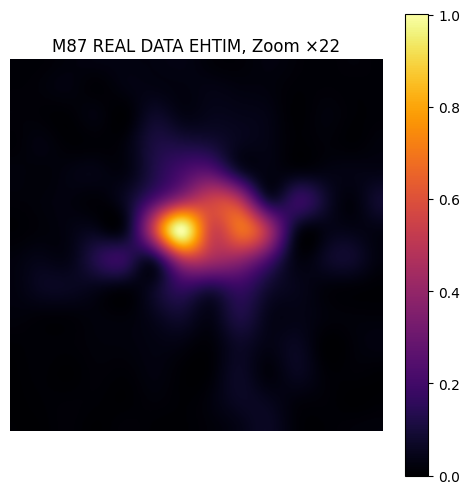

In [55]:
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import numpy as np

# Trova centro massimo
yc, xc = np.unravel_index(np.argmax(image), image.shape)

# Sposta il centro leggermente a sinistra
offset_x = 1# pixel
xc_shifted = max(xc + offset_x, 0)

# Parametri di zoom
zoom_factor = 22
crop_radius = int(20 * 8 / zoom_factor)  # adattato al fattore di zoom

# Crop centrato sul punto spostato
x_start = max(xc_shifted - crop_radius, 0)
x_end = min(xc_shifted + crop_radius, image.shape[1])
y_start = max(yc - crop_radius, 0)
y_end = min(yc + crop_radius, image.shape[0])

cropped = image[y_start:y_end, x_start:x_end]

# Interpolazione bicubica
zoomed = zoom(cropped, zoom_factor, order=3)

# Visualizza
plt.figure(figsize=(6,6))
plt.imshow(zoomed, cmap='inferno', origin='lower', interpolation='quadric')
plt.title(f"M87 REAL DATA EHTIM, Zoom ×{zoom_factor}")
plt.axis('off')
plt.colorbar()
plt.show()

## Mancanza di deconvoluzione
Tu stai mostrando una "dirty image", ovvero:

- Una immagine ottenuta da IFFT diretta

- Convoluta con il dirty beam (cioè il pattern dato dalla copertura UV)

🧨 Questo introduce artefatti e riduce i dettagli rispetto a immagini prodotte da:

1. ehtim (che usa regolarizzazione + selfcal)

2. smili (RML imaging)

3. clean